# Deep-Learning: Introduction to Convolutional Neural Networks

Welcome to a tutorial to get you quickly up to speed with *deep learning*; from first principles, all the way to discussions of some of the intricate details, with the purposes of achieving respectable performance on one established machine learning benchmark: [MNIST](http://yann.lecun.com/exdb/mnist/) (classification of handwritten digits).


MNIST dataset                      
![](http://perso.mines-paristech.fr/fabien.moutarde/ES_MachineLearning/TP_convNets/mnist.png)  

By the end of this part of the tutorial, you should be capable of understanding and producing a simple CNN (with a structure similar to LeNet architecture) in Keras, achieving a respectable level of accuracy on MNIST.


This code assume your already have installed <code>numpy</code>, <code>keras</code>, <code>tensorflow</code>, ... on your computer. If not, uncomment the adequate lines in the cell below:

In [1]:
import sys
print('Your python version: {}'.format(sys.version_info.major))
# Uncomment lines below only if you need them 
#!{sys.executable} -m pip install -U numpy --user
#!{sys.executable} -m pip install -U matplotlib --user
#!{sys.executable} -m pip install -U keras --user
#!{sys.executable} -m pip install -U tensorflow --user
#!{sys.executable} -m pip install -U theano --user

Your python version: 3


In [2]:
USE_TENSORFLOW_AS_BACKEND = True
FORCE_CPU = False

In [3]:
import os
import numpy as np
from numpy import newaxis
import matplotlib.pyplot as plt

In [4]:
#if USE_TENSORFLOW_AS_BACKEND:
#    os.environ['KERAS_BACKEND'] = 'tensorflow'
#else:
#    os.environ['KERAS_BACKEND'] = 'theano'
#if FORCE_CPU:
#    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   
#    os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [5]:
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.datasets import mnist # subroutines for fetching the MNIST dataset
from tensorflow.keras.models import Model, Sequential # basic class for specifying and training a neural network
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten
from tensorflow.keras.utils import to_categorical # utilities for one-hot encoding of ground truth values

In [6]:
#if USE_TENSORFLOW_AS_BACKEND:
#    K.set_image_dim_ordering('tf')
#else:
#    K.set_image_dim_ordering('th')

In [7]:
print('Your keras version: {}'.format(keras.__version__))
if USE_TENSORFLOW_AS_BACKEND == True:
    import tensorflow
    print('Your tensorflow version: {}'.format(tensorflow.__version__))
else:
    import theano
    print('Your theano version: {}'.format(theano.__version__))

Your keras version: 2.6.0
Your tensorflow version: 2.6.2


In [8]:
# --------------------------------------
# Dataset variables
# --------------------------------------
num_train = 60000 # there are 60000 training examples in MNIST
num_test = 10000  # there are 10000 test examples in MNIST
height, width, depth = 28, 28, 1 # MNIST images are 28x28 with 1 channel (greyscale)
num_classes = 10                 # there are 10 classes (1 per digit)

# --------------------------------------
# Dataset loading & preprocessing
# --------------------------------------
(X_train, y_train), (X_test, y_test) = mnist.load_data() # fetch MNIST data
print(X_train.shape, y_train.shape)
X_train = X_train.astype('float32') 
X_test = X_test.astype('float32')
X_train /= 255 # Normalise data to [0, 1] range
X_test /= 255 # Normalise data to [0, 1] range

X_train = X_train[:, :, :,newaxis] # Reshape in "convolutionable" format (add tensor dim for the depth)
X_test = X_test[:, :, :,newaxis] # Reshape in "convolutionable" format (add tensor dim for the depth)

Y_train = to_categorical(y_train, num_classes) # One-hot encode the labels
Y_test = to_categorical(y_test, num_classes) # One-hot encode the labels

print(X_train.shape, Y_train.shape)

(60000, 28, 28) (60000,)
(60000, 28, 28, 1) (60000, 10)


In [11]:
# --------------------------------------
# Network params
# --------------------------------------
# Network params
batch_size = 32    # in each iteration, we consider 32 training examples at once
num_epochs = 10    # we iterate 20 times over the entire training set
kernel_size = 5    # we will use 5x5 kernels throughout
pool_size = 2      # we will use 2x2 pooling throughout
conv_depth_1 = 6   # we will initially have 6 kernels in first conv. layer...
conv_depth_2 = 16  # ...switching to 16 after the first pooling layer
drop_prob_1 = 0.5   # dropout after pooling with probability 0.5
drop_prob_2 = 0.5   # dropout in the FC layer with probability 0.5
hidden_size = 128  # the FC layer will have 128neurons
weight_penalty = 0. # Factor for weights penalty

# --------------------------------------
# CNN network definition
# --------------------------------------
# inp = Input(shape=(1,height,width)) # greyscale --> depth==1
# model = Model(input=inp, output=out) # To define a model, just specify its input and output layers

model = Sequential()
# Conv [8] -> Pool (with dropout on the pooling layer)
model.add( Conv2D(conv_depth_1, (kernel_size,kernel_size), padding='same', activation='relu', data_format="channels_last", input_shape=(28, 28,1)) )
model.add( MaxPooling2D(pool_size=(pool_size, pool_size)))
model.add( Dropout(drop_prob_1) )

# Conv [16] -> Pool (with dropout on the pooling layer)
model.add( Conv2D(conv_depth_2, (kernel_size,kernel_size), padding='same', activation='relu') )
model.add( MaxPooling2D(pool_size=(pool_size, pool_size)) )
model.add( Dropout(drop_prob_1) )

# Now flatten to 1D, apply FC -> ReLU (with dropout) -> softmax
model.add( Flatten() )
model.add( Dense(hidden_size, activation='relu', kernel_regularizer=regularizers.l2(weight_penalty)) )
model.add( Dropout(drop_prob_2) )
model.add( Dense(num_classes, activation='softmax') )

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 16)        2416      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 7, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)              

In [12]:
# --------------------------------------
# Loss function and Optimizer
# --------------------------------------
model.compile(loss='categorical_crossentropy', # using the cross-entropy loss function
              optimizer='adam', # using the Adam optimiser
              metrics=['accuracy']) # reporting the accuracy

# --------------------------------------
# Training
# --------------------------------------
history = model.fit(X_train, Y_train, # Train the model using the training set...
          batch_size=batch_size, epochs=num_epochs,
          verbose=1, validation_split=0.4) # ...holding out 40% of the data for validation

# --------------------------------------
# Evaluation
# --------------------------------------
for loss_name, loss_value in list(zip(model.metrics_names, model.evaluate(X_test, Y_test, verbose=1))):
    print('The final {} on the test set is: {:.2f}.'.format(loss_name, loss_value)) # Evaluate the trained model on the test set!

Epoch 1/10
1125/1125 [==============================] - 88s 75ms/step - loss: 0.5998 - accuracy: 0.8041 - val_loss: 0.1458 - val_accuracy: 0.9605
Epoch 2/10
1125/1125 [==============================] - 84s 74ms/step - loss: 0.2804 - accuracy: 0.9130 - val_loss: 0.1012 - val_accuracy: 0.9703
Epoch 3/10
1125/1125 [==============================] - 89s 80ms/step - loss: 0.2382 - accuracy: 0.9261 - val_loss: 0.0875 - val_accuracy: 0.9757
Epoch 4/10
1125/1125 [==============================] - 83s 74ms/step - loss: 0.2087 - accuracy: 0.9373 - val_loss: 0.0795 - val_accuracy: 0.9765
Epoch 5/10
1125/1125 [==============================] - 72s 64ms/step - loss: 0.1889 - accuracy: 0.9416 - val_loss: 0.0733 - val_accuracy: 0.9779
Epoch 6/10
1125/1125 [==============================] - 10s 9ms/step - loss: 0.1830 - accuracy: 0.9430 - val_loss: 0.0755 - val_accuracy: 0.9780
Epoch 7/10
1125/1125 [==============================] - 11s 9ms/step - loss: 0.1767 - accuracy: 0.9457 - val_loss: 0.0699 - v

**Plot the training history, in order to check if overfitting seems to have occured or not, and if more training epochs could be performed.**


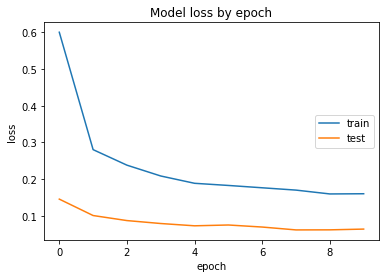

In [13]:
# --------------------------------------
# Loss functions evolution
# --------------------------------------
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()

